## Batch NormalizationとLayer Normarlization

## Hook

### .register_hook

In [62]:
# ライブラリ
from functools import partial
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
import utils
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
a = torch.ones(5, requires_grad=True)
b = 2*a
# 中間gradを保持
b.retain_grad()

# ここに追加

def print_grad(grad):
    print(grad)
b.register_hook(print_grad)

"""
lambda関数を使って省略
b.register_hook(lambda grad: print(grad))
"""

c = b.mean()

# backward
c.backward()


In [ ]:
print(a)
print(b)
print(c)

In [ ]:
print(a.grad)
print(b.grad)

### .register_forward_hook()

In [ ]:
# modelを定義する
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(), 

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Flatten(),
    # 128 -> 32
    nn.Linear(128, 10)
    
)


In [ ]:
outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape
    

In [ ]:
# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    # print(name, module)
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_forward_hook(partial(save_output, name))
        

In [ ]:
def print_hooks(model):
    for name , module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook : {hook}')
    
    for name , module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook : {hook}')

In [ ]:
print_hooks(conv_model)

In [ ]:
from functools import partial

# 元となる関数を定義
def power(base, exponent):
    return base ** exponent

# 部分適用した関数を適用
square = partial(power, exponent=2)

# 部分適用した関数の利用
print(square(5))  # 出力25


### forwardでhookを発動

In [ ]:
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

In [ ]:
outputs

## .register_full_backward_hook()

In [ ]:
grads = {}
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in

# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    # print(name, module)
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_full_backward_hook(partial(save_grad_in, name))
        

In [ ]:
print_hooks(conv_model)

In [ ]:
# backward 
X = torch.rand((1, 1, 28, 28))
output = conv_model(X)
loss = output.mean()
loss.backward()

In [ ]:
grads

In [ ]:
## Activationの分布

In [183]:
# model 
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    # 32x2x2
    nn.Flatten(),
    nn.Linear(128, 10)

)

outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape

# 出力のshapeをdictに保存
for name, module in conv_model.named_modules():
    if name: 
        module.register_forward_hook(partial(save_output, name))
        

In [184]:
# forward 
# for module in conv_model:
#     print(module)
# # relu分のリストを作成
act_means = [[]  for module in conv_model if isinstance(module, nn.ReLU)]
act_stds = [[]  for module in conv_model if isinstance(module, nn.ReLU)]

def save_out_stats(i, module, inp, out):
    act_means[i].append(out.mean().item())
    act_stds[i].append(out.std().item())
    
relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
for i, relu in enumerate(relu_layers):
    relu.register_forward_hook(partial(save_out_stats, i))

# 上記のものをclass化する

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

In [185]:
act_stats = ActivationStatistics(conv_model)

In [186]:
[module for module in conv_model if isinstance(module, nn.ReLU)]

[ReLU(), ReLU(), ReLU(), ReLU()]

In [187]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
])



train_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = False, download=True, transform=transform)

# dataloader 
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1024, num_workers=4)


In [188]:
opt = optim.SGD(conv_model.parameters(), lr=0.6)

In [189]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)


epoch: 0: train error: 2.275512456893921, validation error: 2.6869499921798705, validation accuracy: 0.12234933003783226


epoch: 1: train error: 2.152744275028423, validation error: 1.940973162651062, validation accuracy: 0.361712771654129


epoch: 2: train error: 1.517847305637295, validation error: 1.0755438029766082, validation accuracy: 0.6029177308082581


In [190]:
act_means, act_stds = act_stats.get_statstics()

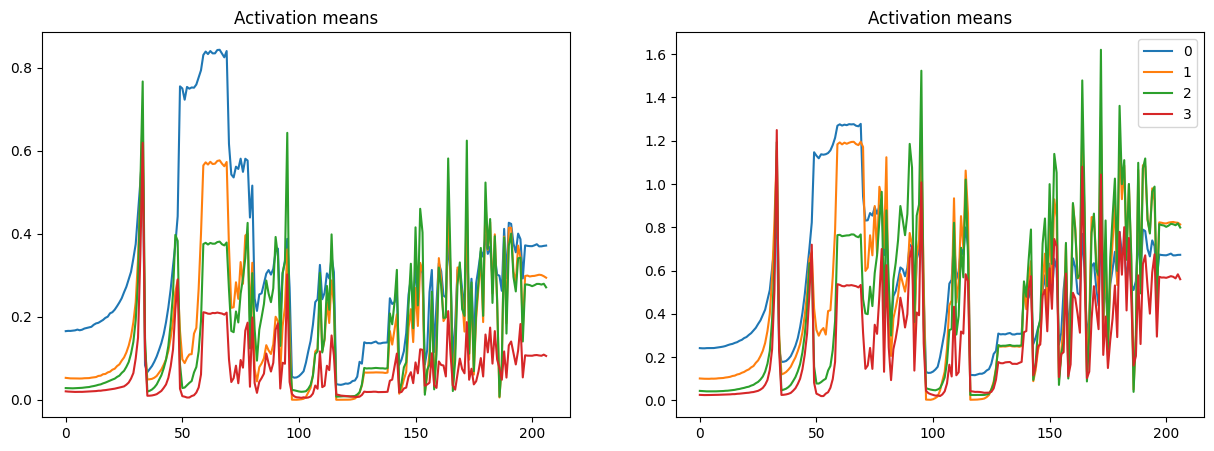

In [191]:
act_stats.plot_statistics()

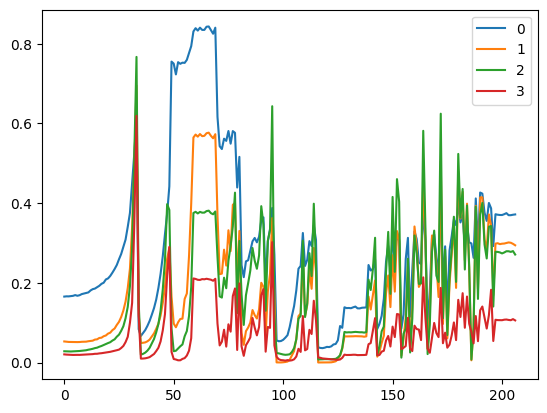

In [192]:
# act_means   # [[], [], [], []]
for act_mean in act_means:
    plt.plot(act_mean)

plt.legend(range(len(act_means)))

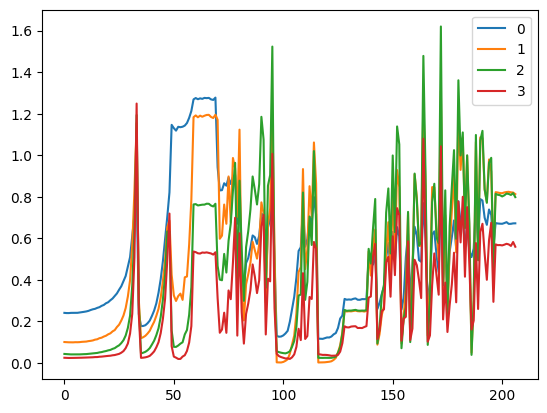

In [193]:
# act_means   # [[], [], [], []]
for act_std in act_stds:
    plt.plot(act_std)

plt.legend(range(len(act_std)))

このグラフから何を言っているのかと
1層目のReLU層の平均値をみると、stepがめっちゃ上がって下がって、いる
-> 学習がしにくい状況になっている
つまり、分布が変わっている
各Activation分布を見ることで、学習が滑らかに進んではいない
平均が上がったり、下がったりしている -> 内部共変量が起きている